In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import *
from tqdm import tqdm
from utils import LoadRumoursDataset
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pylab as plt
import uuid
from tqdm import tqdm
import seaborn as sns

In [3]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"


In [4]:
time_cut =1e6
processor = LoadRumoursDataset(file_path_replies, file_path_posts, time_cut)
processor.load_data()
processor.process_data()
df_final = processor.get_final_dataframe()
df_final['id'] = [uuid.uuid4() for _ in range(len(df_final))]


In [5]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [7]:
X  = df_final.drop(columns=['rumour','id'])
X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
y =df_final['rumour']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42,stratify=y,shuffle=True
)

In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

def modelfit(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    # Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]

    # Predict test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    
    # Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='recall')
    
    # Print model report for Train:
    print("\nModel Report Train")
    print("AUC Score : %f" % roc_auc_score(y_train, dtrain_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
    print("Precision : %.4g" % precision_score(y_train, dtrain_predictions))
    print("Recall : %f" % recall_score(y_train, dtrain_predictions))
    
    # Plot confusion matrix for Train
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_train, dtrain_predictions), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Train")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    # Print model report for Test:
    print("\nModel Report Test")
    print("AUC Score : %f" % roc_auc_score(y_test, dtest_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_test, dtest_predictions))
    print("Precision : %.4g" % precision_score(y_test, dtest_predictions))
    print("Recall : %f" % recall_score(y_test, dtest_predictions))
    
    # Plot confusion matrix for Test
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test, dtest_predictions), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Test")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.tight_layout()
    plt.show()
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

    return alg




Model Report Train
AUC Score : 0.934549
Accuracy : 0.8829
Precision : 0.7651
Recall : 0.686901

Model Report Test
AUC Score : 0.897504
Accuracy : 0.8502
Precision : 0.6803
Recall : 0.619403


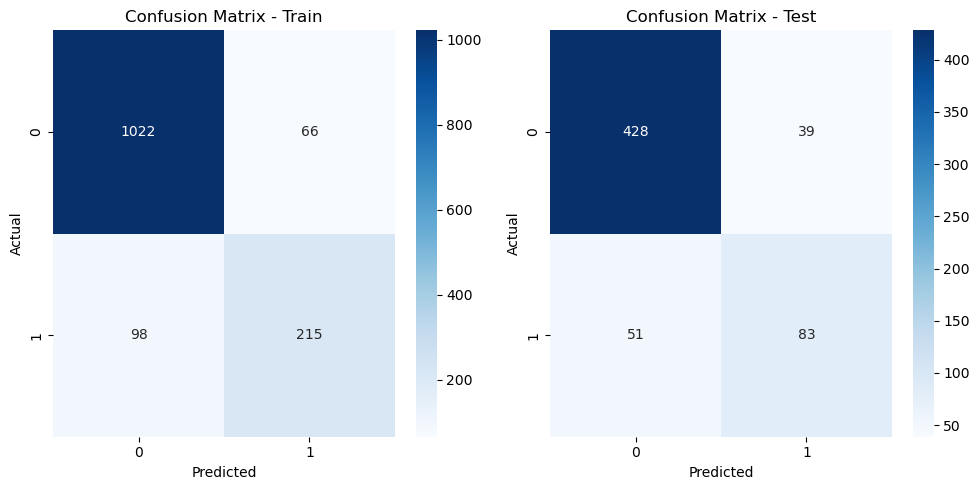

CV Score : Mean - 0.6581669 | Std - 0.04971872 | Min - 0.5873016 | Max - 0.7301587


LogisticRegression(max_iter=1000, random_state=42)

In [12]:
# Fit a standard logistic regression model
lr_model = LogisticRegression(random_state=42,max_iter=1000)
modelfit(lr_model, X_train, y_train,X_test,y_test)


Model Report Train
AUC Score : 0.934549
Accuracy : 0.8829
Precision : 0.7651
Recall : 0.686901

Model Report Test
AUC Score : 0.897504
Accuracy : 0.8502
Precision : 0.6803
Recall : 0.619403


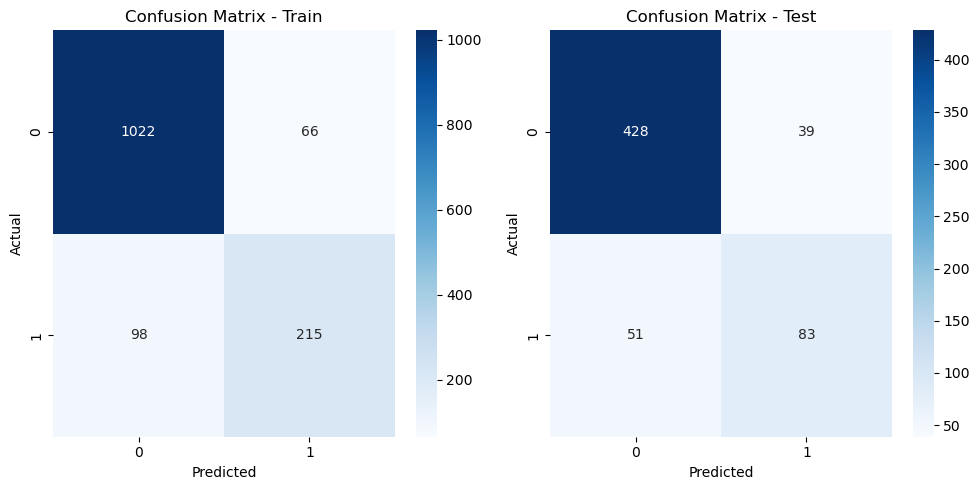

CV Score : Mean - 0.6581669 | Std - 0.04971872 | Min - 0.5873016 | Max - 0.7301587


LogisticRegression(max_iter=1000, random_state=42)

In [27]:
# Fit a standard logistic regression model
# Fit a weighted logistic regression model
weights = {0: 1, 1: 1.3} # Weight 10 for class 1 (minority class)
weighted_lr_model = LogisticRegression(random_state=42, class_weight=weights,max_iter=1000)

modelfit(lr_model, X_train, y_train,X_test,y_test)

In [16]:
param_grid = [
    {'penalty':['l1','l2','elasticnet','none'],
    'C' : np.logspace(-4,4,20),
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter'  : [100,1000,2500,5000]
}
]

In [19]:
from sklearn.model_selection import GridSearchCV
log_model = LogisticRegression()
clf = GridSearchCV(log_model,param_grid = param_grid, cv = 3, verbose=True,n_jobs=-1)